Join the data from Part 1 with the data from Part 2 to create a new dataframe.

In [191]:
#imports
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
from sqlite3 import Error

#display all columns in dataframes
pd.set_option('display.max_columns', None)

In [212]:
#import bike stations, places and businesses dataframes, along with the GPT category mapping dataframe
bike_stations = pd.read_json('stations.json')
FS_places = pd.read_json('FS_POIS.json')
YELP_businesses = pd.read_json('YELP_POIS.json')
GPT_categories = pd.read_json('GPT_df.json')

#before merging the dataframes the columns of each dataframe need to be renamed to distinct names
#create lists of ne column names
bike_stations_new_cols = ['empty_slots', 'free_bikes', 'station.latitude', 'station.longitude']
FS_places_new_cols = ['FS.distance', 'FS.name', 'FS.latitude', 'FS.longitude','FS.address', 'FS.categories']
YELP_businesses_new_cols = ['YELP.name', 'rating','review_count', 'YELP.distance', 'YELP.latitude','YELP.longitude', 'YELP.address', 'price', 'YELP.categories']

#assign new column names to each dataframe
bike_stations.columns=bike_stations_new_cols
FS_places.columns=FS_places_new_cols
YELP_businesses.columns=YELP_businesses_new_cols

#add a station id to each bike station
bike_stations['station_id']=bike_stations.index
bike_stations.head()

,empty_slots,free_bikes,station.latitude,station.longitude,station_id
0,13,3,37.548877,-77.442697,0
1,11,1,37.568589,-77.441463,1
2,15,1,37.516124,-77.444372,2
3,18,1,37.551472,-77.451937,3
4,23,0,37.553716,-77.455681,4


In [213]:
"""
According to the United States Geological Survey: 
At 38 degrees North latitude, near Richmond 
a change in distance of 1000m corresponds to a change of ±0.0090 latitude and ±0.0114 longitude
"""

#create columns indicating the coordinates of the search limits around each station
north_latitude=[]
south_latitude=[]
west_longitude=[]
east_longitude=[]
for i in range(len(bike_stations)):
    north_latitude.append(bike_stations['station.latitude'][i]+0.0090)
    south_latitude.append(bike_stations['station.latitude'][i]-0.0090)
    west_longitude.append(bike_stations['station.longitude'][i]-0.0114)
    east_longitude.append(bike_stations['station.longitude'][i]+0.0114)
bike_stations['north_latitude']=north_latitude
bike_stations['south_latitude']=south_latitude
bike_stations['west_longitude']=west_longitude
bike_stations['east_longitude']=east_longitude

"""
Since Foursquare returns fewer results and less detailed information than YELP, Foursquare results will be excluded from the data analysis and modelling.

clean YELP results by: 
sorting YELP_businesses by ascending distance to nearest bike station and 
removing rows containing duplicated business names
"""
print(len(YELP_businesses))
YELP_businesses=YELP_businesses.sort_values('YELP.distance').drop_duplicates('YELP.name')
print(len(YELP_businesses))  

951
550


In [214]:
#401 duplicated rows were removed

#assign each Yelp business to its nearest bike_station
nearest_station = {}
yelp_names=YELP_businesses.set_index('YELP.name')
station_ids=bike_stations.set_index('station_id')
for name in yelp_names.index:
    for station in station_ids.index:
        if (
            (yelp_names.loc[name, 'YELP.latitude']<=station_ids.loc[station,'north_latitude']) &
            (yelp_names.loc[name, 'YELP.latitude']>=station_ids.loc[station,'south_latitude']) &
            (yelp_names.loc[name, 'YELP.longitude']>=station_ids.loc[station,'west_longitude']) &
            (yelp_names.loc[name, 'YELP.longitude']<=station_ids.loc[station,'east_longitude'])
            ):
            nearest_station.update({name:station})
        else:
                                    continue
                
#verify if every bussiness has been assigned bike station
print(len(YELP_businesses))
print(len(nearest_station))

550
541


In [215]:
# display the 9 businesses that could not be assigned to a bike station
YELP_businesses[~YELP_businesses['YELP.name'].isin(nearest_station.keys())]

,YELP.name,rating,review_count,YELP.distance,YELP.latitude,YELP.longitude,YELP.address,price,YELP.categories
343,The Mantu,4.0,173,115.661916,37.543660,-77.484440,23221-0000,$$,Afghan
342,Copper Kettle,5.0,1,115.661916,54.388401,-1.941740,Galway House,None,Restaurants
341,Moidul's Hampton Wick Tandoori,4.5,3,115.661916,51.412956,-0.311063,36-38 High St,None,Indian
340,Sustenance Food Truck,2.0,1,115.661916,NaN,NaN,,$$,Street Vendors
339,Farmers Arms,3.0,1,115.661916,54.376400,-2.140300,,££,Pubs
337,Foxhall Inn,4.0,1,115.661916,54.477410,-1.772372,,£££,Pubs
338,Kings Head,5.0,1,115.661916,54.379450,-2.075520,,None,Pubs
336,Shoulder Of Mutton Inn,2.0,1,115.661916,54.453871,-1.785736,,None,Pubs
500,Pyecombe Church,5.0,1,325.833094,50.897824,-0.163582,Church Hill,None,Landmarks & Historical Buildings


In [216]:
#looking at the coordinates of these businesses it seems clear that all of them , except 'The Mantu', are incorrect results returned by the Yelp API
#for simplicity all 9 businesses will be removed from YELP_businesses

#drop the incorrect results from YELP_businesses
incorrect_businesses = YELP_businesses[~YELP_businesses['YELP.name'].isin(nearest_station.keys())]
business_to_remove = list(incorrect_businesses['YELP.name'])
YELP_businesses=YELP_businesses[~YELP_businesses['YELP.name'].isin(business_to_remove)]

#add the column "nearest_station" to YELP_businesses in order to correlate it to the bike_stations dataframe.
YELP_businesses['nearest_station']=YELP_businesses['YELP.name'].map(nearest_station)


#merge dataframes YELP_businesses and bike_stations, on YELP_businesses['nearest_station'] == bike_stations['station_id']
merged_businesses_stations = pd.merge(bike_stations, YELP_businesses, how='inner', left_on='station_id', right_on='nearest_station')

#finally, merge the dataframes merged_businesses_stations and GPT_categories
businesses = pd.merge(merged_businesses_stations, GPT_categories, how='left', left_on='YELP.categories', right_on='Business_Cate')
businesses.head()


,empty_slots,free_bikes,station.latitude,station.longitude,station_id,north_latitude,south_latitude,west_longitude,east_longitude,YELP.name,rating,review_count,YELP.distance,YELP.latitude,YELP.longitude,YELP.address,price,YELP.categories,nearest_station,Business_Cate,Place_Cate
0,11,1,37.568589,-77.441463,1,37.577589,37.559589,-77.452863,-77.430063,Popeyes Louisiana Kitchen,1.5,54,237.035506,37.568280,-77.444040,2709 Chamberlayne Ave,$,Chicken Wings,1,Chicken Wings,Fried Chicken Joint
1,11,1,37.568589,-77.441463,1,37.577589,37.559589,-77.452863,-77.430063,Captain D's,4.0,8,249.010884,37.567862,-77.444135,2701 Chamberlayne Ave,$,Seafood,1,Seafood,Restaurant
2,11,1,37.568589,-77.441463,1,37.577589,37.559589,-77.452863,-77.430063,Red Harbor Seafood N Chicken,4.0,13,336.555225,37.567331,-77.444936,2606A Chamberlayne Ave,None,Seafood,1,Seafood,Restaurant
3,11,1,37.568589,-77.441463,1,37.577589,37.559589,-77.452863,-77.430063,Sugar's Crab Shack,4.5,161,607.440572,37.563580,-77.444110,2224 Chamberlayne Ave,$$,Southern,1,Southern,Restaurant
4,11,1,37.568589,-77.441463,1,37.577589,37.559589,-77.452863,-77.430063,Sugars crab shack,5.0,3,607.440572,37.563588,-77.444190,2224 Chamberlayne Ave,None,Seafood,1,Seafood,Restaurant


In [218]:
#verify data types
businesses.dtypes

#of all the columns only "price" need conversion to a more useful format
#businesses['price'].unique() reveals 'price' has four price levels: '$', '$$', '$$$', and '$$$$'

#create dictionary to add a numeric 'price' column
symbol_to_number = {'$':1, '$$':2, '$$$':3, '$$$$':4}

#add column numeric_price to businesses dataframe
businesses['numeric_price']=businesses['price'].map(symbol_to_number)

#select relevant columns
businesses_cols=['nearest_station','empty_slots','free_bikes','YELP.name','rating','review_count','YELP.distance','price','numeric_price','Place_Cate']

#create working dataframe with relevant columns
business_df = businesses[businesses_cols]

#finally, rename the columns
business_df=business_df.rename(columns={'empty_slots':'empty_bike_slots','free_bikes':'available_bikes','YELP.name':'business_name','YELP.distance':'dist_to_station','Place_Cate':'business_type'})

#save and display dataframe
business_df.to_json('business.json')
business_df.head()

,nearest_station,empty_bike_slots,available_bikes,business_name,rating,review_count,dist_to_station,price,numeric_price,business_type
0,1,11,1,Popeyes Louisiana Kitchen,1.5,54,237.035506,$,1.0,Fried Chicken Joint
1,1,11,1,Captain D's,4.0,8,249.010884,$,1.0,Restaurant
2,1,11,1,Red Harbor Seafood N Chicken,4.0,13,336.555225,None,NaN,Restaurant
3,1,11,1,Sugar's Crab Shack,4.5,161,607.440572,$$,2.0,Restaurant
4,1,11,1,Sugars crab shack,5.0,3,607.440572,None,NaN,Restaurant


Provide a visualization that you used as part of your EDA process. Explain the initial pattern or relationship you discoved through this visualization. 

C:\Users\mario\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


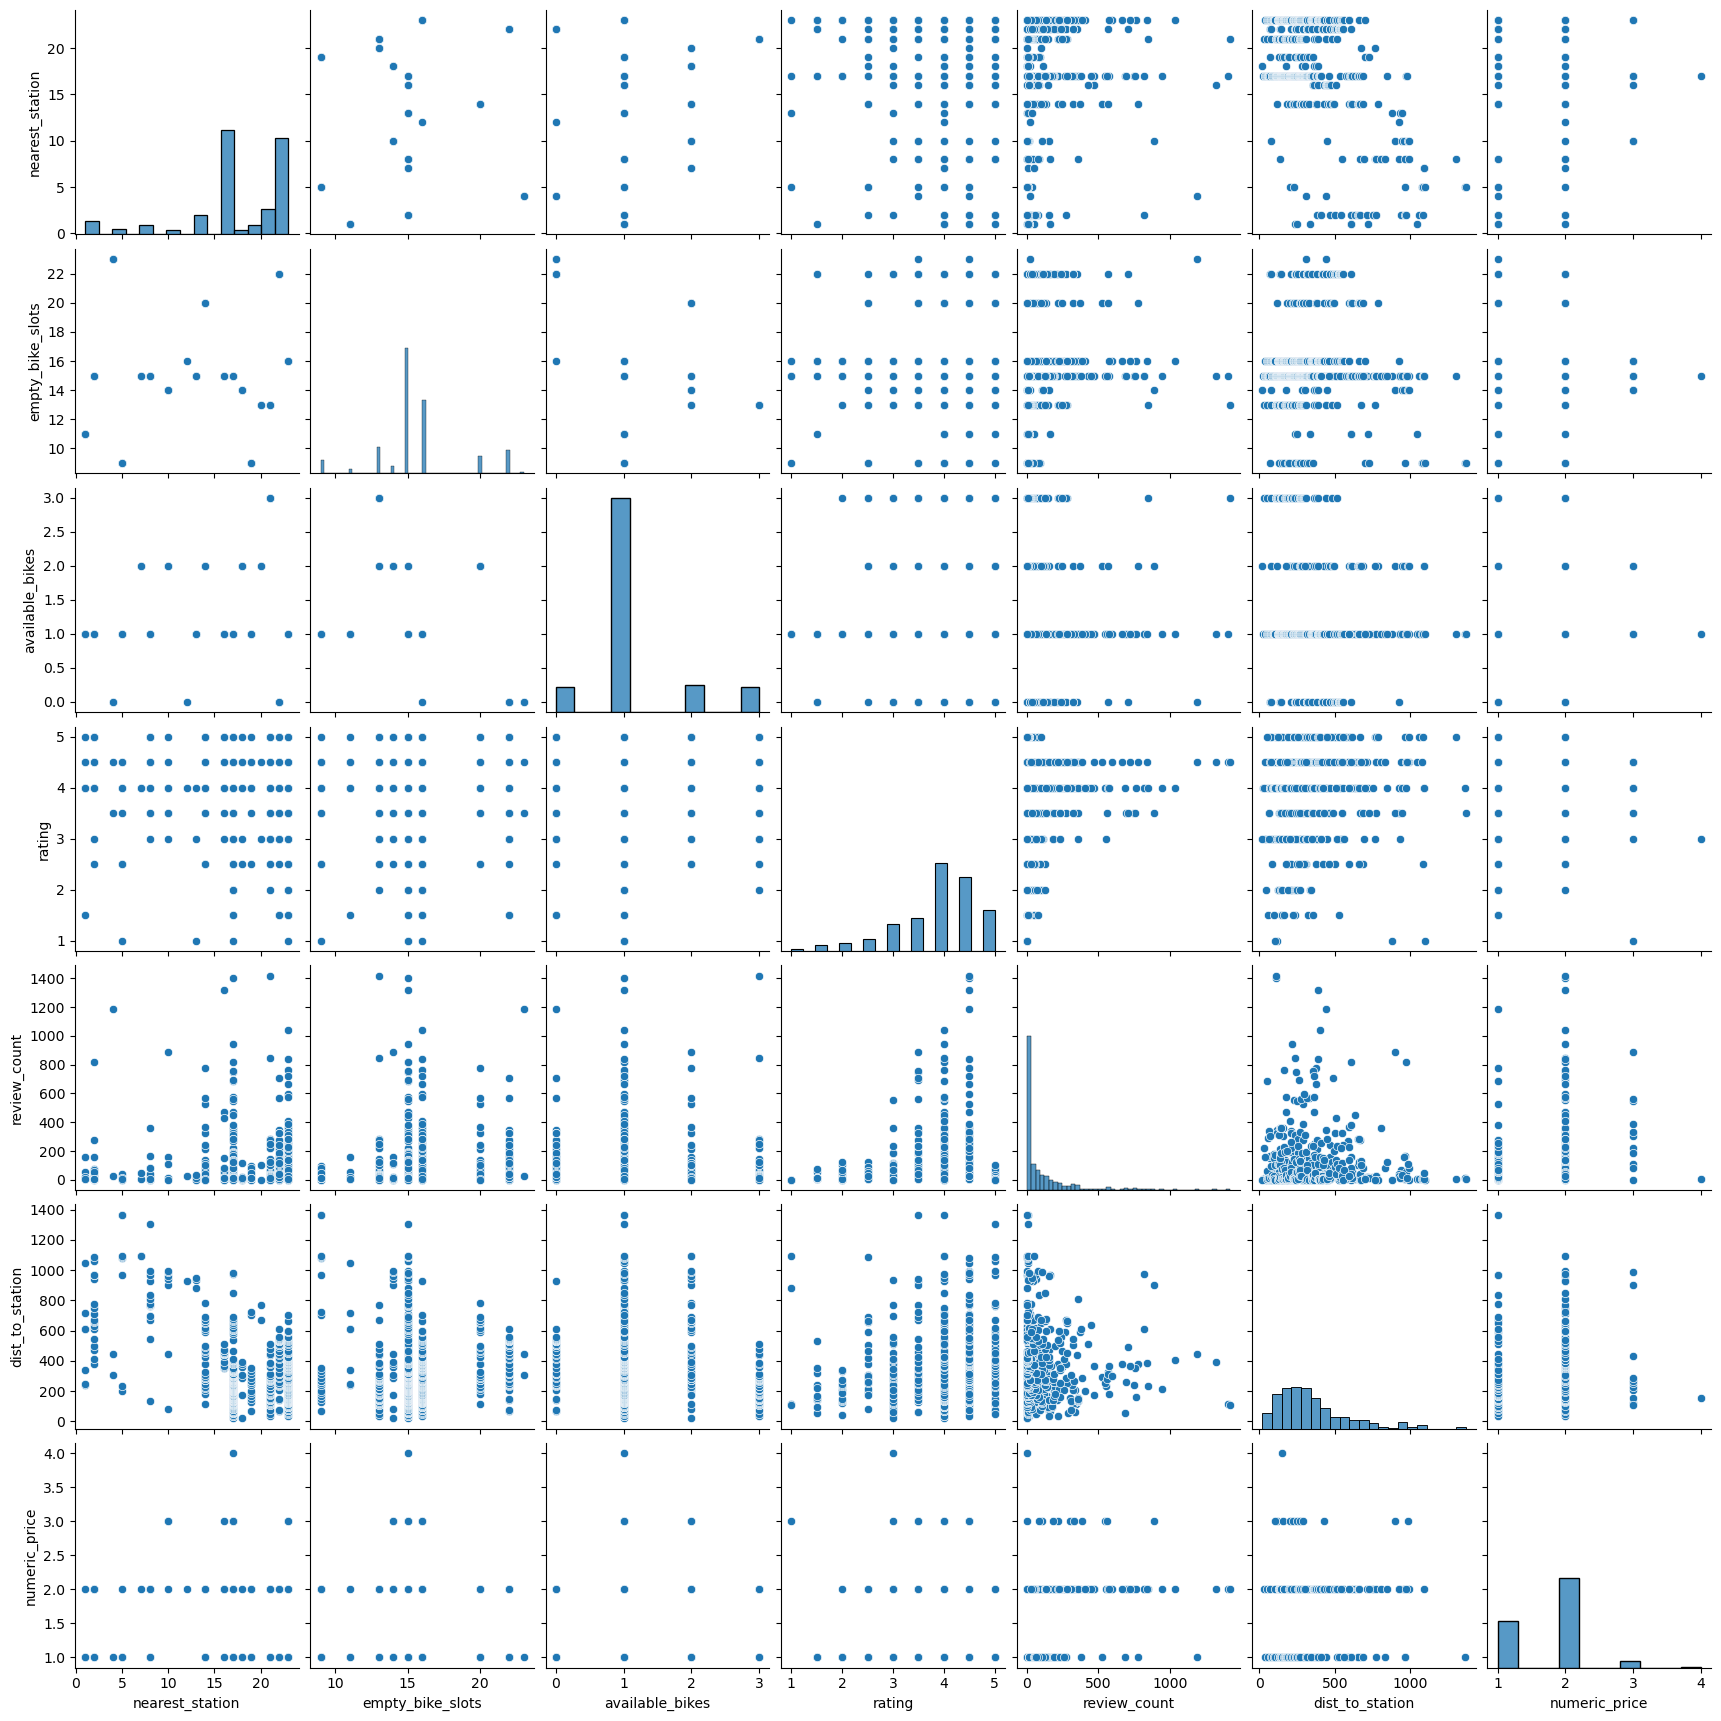

In [219]:
#examine data using scatter plots and histograms
sns.pairplot(business_df)
plt.savefig('C:/Users/mario/Desktop/LHL Data Science/Statistical_Modelling_Project/images/businness_bike_stations_pairplots.png')
plt.show()

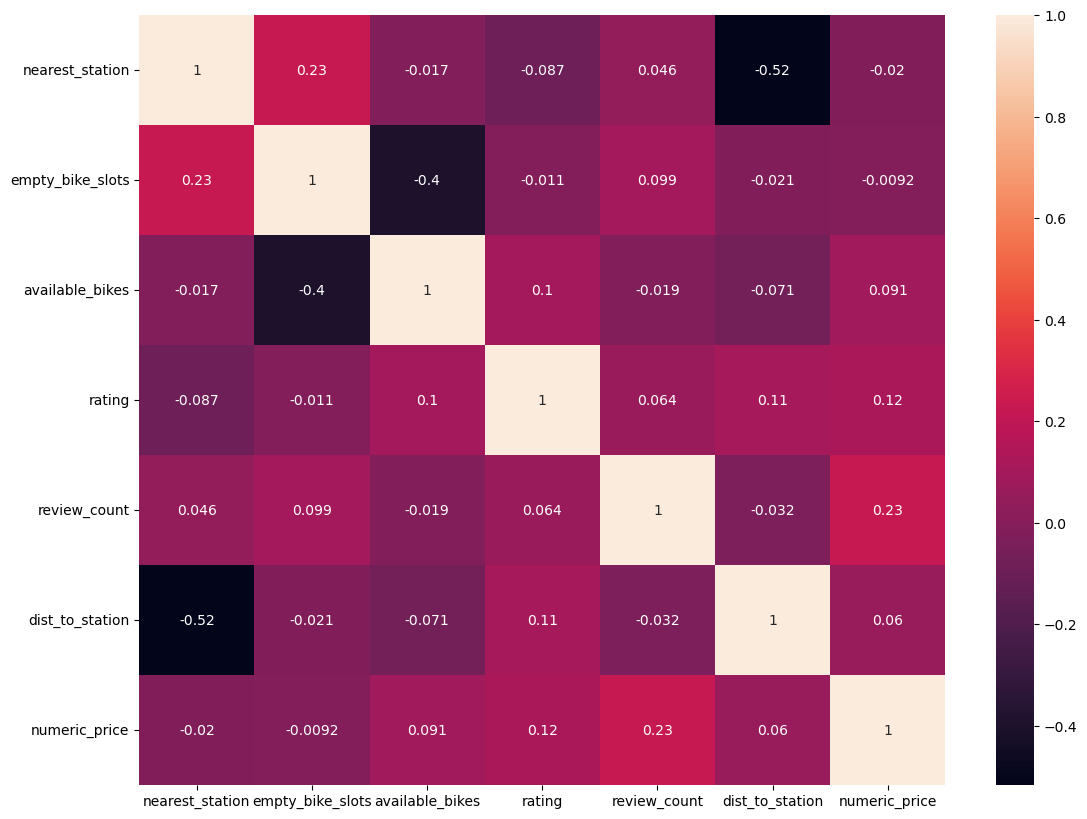

In [223]:
#examine data using correlation heatmap
plt.figure(figsize=(13,10))
sns.heatmap(business_df.select_dtypes(include=['number']).corr(), annot=True)
plt.savefig('C:/Users/mario/Desktop/LHL Data Science/Statistical_Modelling_Project/images/businness_bike_stations_corr_heatmap.png')
plt.show()

In [224]:
#Unfortunately, there doesn't seems to be any meaningful correlations between columns with numeric values in the business dataframe.

#find the average distance between business and the nearest bike station.
business_df['dist_to_station'].mean()
#aprox. 350m

#find the average Yelp rating of businesses in Richmond
business_df['rating'].mean()
#3.92 out of 5.0

3.9279112754158967

# Database

Put all your results in an SQLite3 database (remember, SQLite stores its databases as files in your local machine - make sure to create your database in your project's data/ directory!)

In [228]:
#create a function returning the database connection
def create_connection(path):
    connection = None
    try:
        connection = sqlite3.connect(path)
        print("Connection to SQLite DB successful")
    except Error as e:
        print(f"The error '{e}' occurred")
    return connection

#create the Businesses_and_Bikes database
connection = create_connection('C:/Users/mario/Desktop/LHL Data Science/Statistical_Modelling_Project/data/Businesses_and_Bikes.sqlite')

#create database tables
bike_stations.to_sql("BikeStations", connection, if_exists="replace", index=False)
YELP_businesses.to_sql("YelpBusinesses", connection, if_exists="replace", index=False)
FS_places.to_sql("FoursquarePlaces", connection, if_exists="replace", index=False)
GPT_categories.to_sql("Business_to_Place_categories", connection, if_exists="replace", index=False)

#create a function to send queries to the database
def execute_read_query(connection, query):
    cursor = connection.cursor()
    result = None
    try:
        cursor.execute(query)
        result = cursor.fetchall()
        return result
    except Error as e:
        print(f"The error '{e}' occurred")
        
#retrieve the first 5 rows of table YelpBusinesses, to verify operation of the database
pd.DataFrame(execute_read_query(connection, 'SELECT * FROM YelpBusinesses LIMIT 5'))

Connection to SQLite DB successful


,0,1,2,3,4,5,6,7,8,9
0,Abner Clay Park,3.0,1,18.736233,37.549500,-77.442210,200 W Clay St,None,Tennis,18
1,Reconciliation Statue,4.0,5,21.970997,37.534569,-77.430344,E Main st & N 15th St,None,Landmarks & Historical Buildings,17
2,GWARbar,4.0,220,32.409206,37.548760,-77.443033,217 W Clay St,$$,Barbeque,21
3,Gigi Tea Time,4.5,157,37.519324,37.553480,-77.455490,1355 W Broad St,$,Bubble Tea,23
4,City Hall Observation Deck,4.0,13,37.730548,37.540969,-77.432983,900 E Broad St,None,Landmarks & Historical Buildings,17


Look at the data before and after the join to validate your data.

In [229]:
#inner join tables BikeStations and YelpBusinesses on statiton_id==nearest_station and compare the number of rows against len(business_df) to verify that Pandas and SQLite are working the same way

#for database
print(execute_read_query(connection, 'SELECT count(*) FROM YelpBusinesses AS YB join BikeStations AS BS on YB.nearest_station=BS.station_id'),'rows in merged table')

#for dataframe
print(len(business_df),'rows in merged dataframe')

[(541,)] rows in merged table
541 rows in merged dataframe


In [227]:
#database works as expected.

#end connection to Businesses_and_Bikes
connection.close()